In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from typing import Dict, List, Optional, Sequence, Tuple
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi

from IPython import display
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Creating the required variables
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [3]:
# Setting the path and loading the data
data_dir = pathlib.Path('samples/Basic Beats')

filenames = glob.glob(str(data_dir/'*.mid*'))
print('Number of files:', len(filenames))

Number of files: 10


In [23]:
# analyzing and working with a sample file

sample_file = filenames[1]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

# Extracting the notes
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={note_name}, duration={duration:.4f}')

samples\Basic Beats\Basicbeat_0002.mid
Number of instruments: 1
Instrument name: Acoustic Grand Piano
0: pitch=42, note_name=F#2, duration=0.0930
1: pitch=42, note_name=F#2, duration=0.0930
2: pitch=36, note_name=C2, duration=0.3547
3: pitch=42, note_name=F#2, duration=0.0930
4: pitch=42, note_name=F#2, duration=0.0930
5: pitch=38, note_name=D2, duration=0.3503
6: pitch=42, note_name=F#2, duration=0.0930
7: pitch=42, note_name=F#2, duration=0.0930
8: pitch=42, note_name=F#2, duration=0.0930
9: pitch=36, note_name=C2, duration=0.3503


In [24]:
# Extracting the notes from the sample MIDI file
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    df = pd.DataFrame({name: np.array(value) for name, value in notes.items()})
    df.name = midi_file
    return df

sample_file = filenames[0]
raw_notes = midi_to_notes(sample_file)
raw_notes.head(20)

,pitch,start,end,step,duration
0,42,0.000000,0.088663,0.000000,0.088663
1,36,0.000000,0.172965,0.000000,0.172965
2,42,0.174419,0.263081,0.174419,0.088663
3,42,0.348837,0.437500,0.174419,0.088663
4,38,0.348837,0.521802,0.000000,0.172965
5,42,0.523255,0.611918,0.174418,0.088663
6,42,0.622093,0.710755,0.098837,0.088663
7,42,0.697674,0.710755,0.075581,0.013081
8,42,0.872093,0.960755,0.174419,0.088663
9,36,0.872093,1.045058,0.000000,0.172965


In [5]:
# Converting to note names by considering the respective pitch values

get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
# Visualizing the paramaters of the muscial notes of the piano

def plot_piano_roll(notes: pd.DataFrame, count: int | None = None):
    if count:
        title = f'{notes.name}: First {count} notes'
    else:
        title = f'{notes.name}: Whole track'
        count = len(notes['pitch'])

        plt.figure(figsize=(20, 4))
        plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
        plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)

        plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
        plt.xlabel('Time [s]')
        plt.ylabel('Pitch')
        _ = plt.title(title)

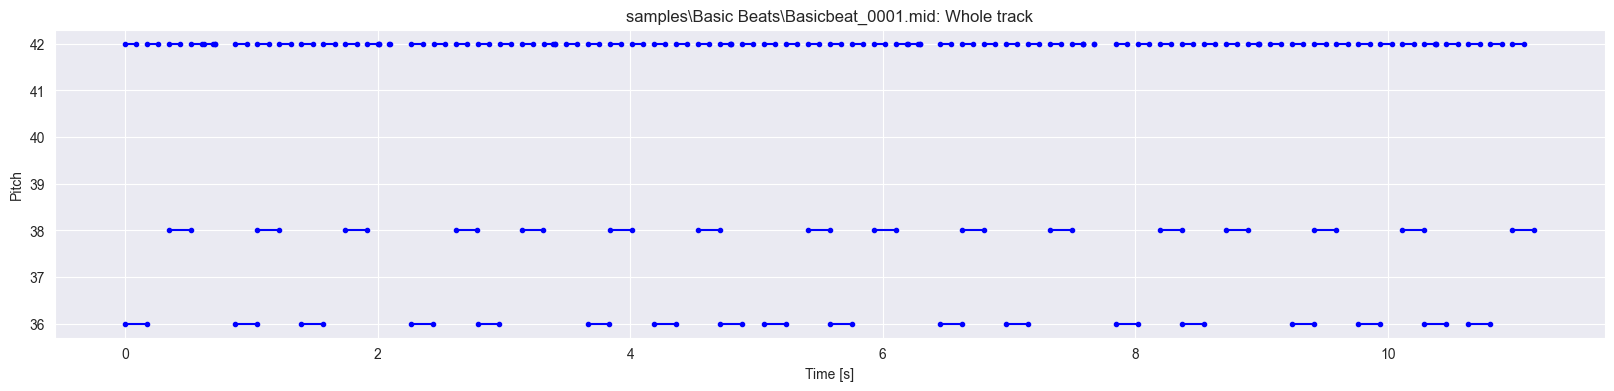

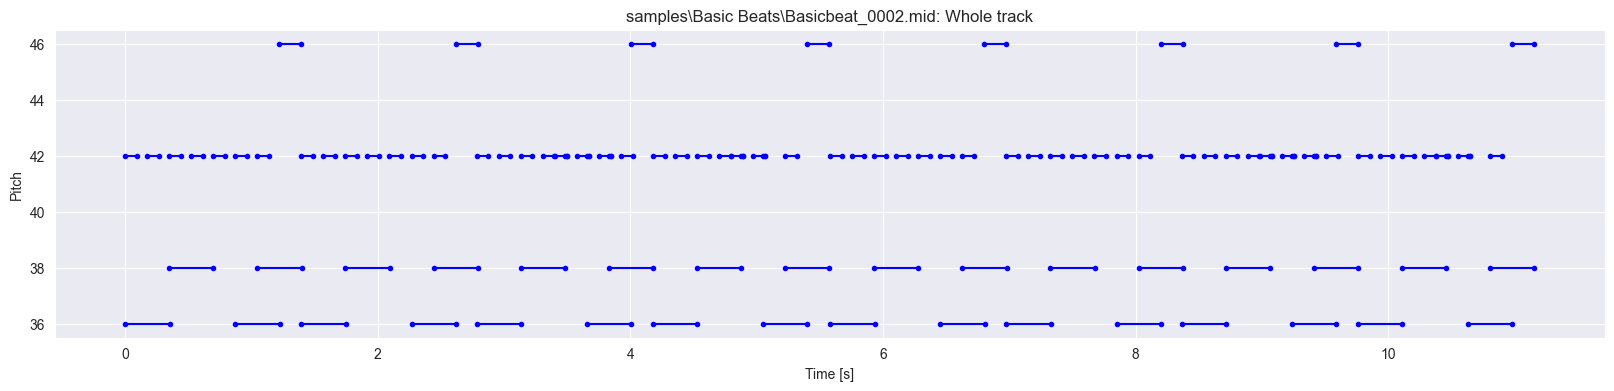

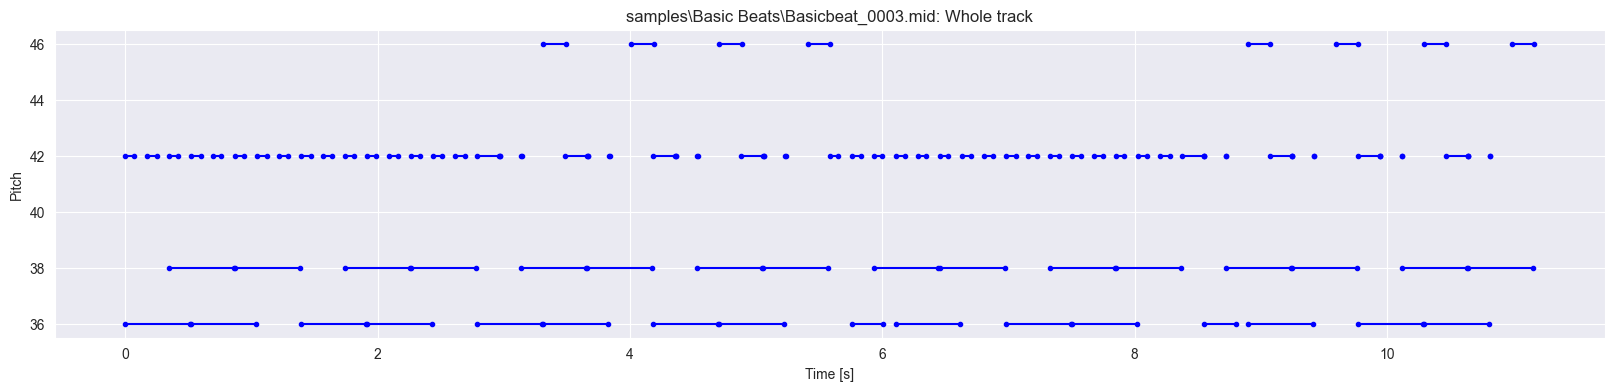

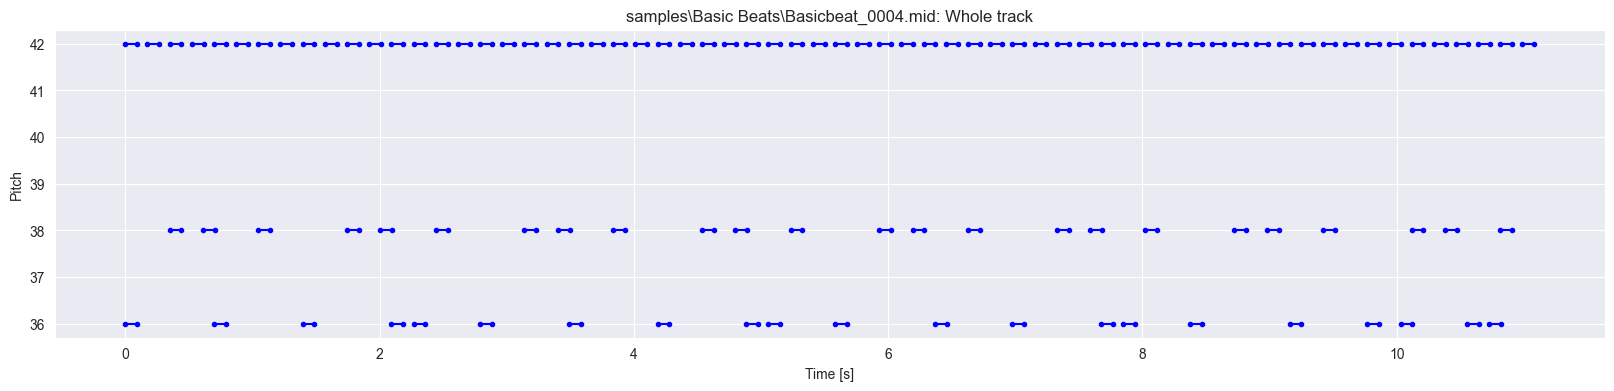

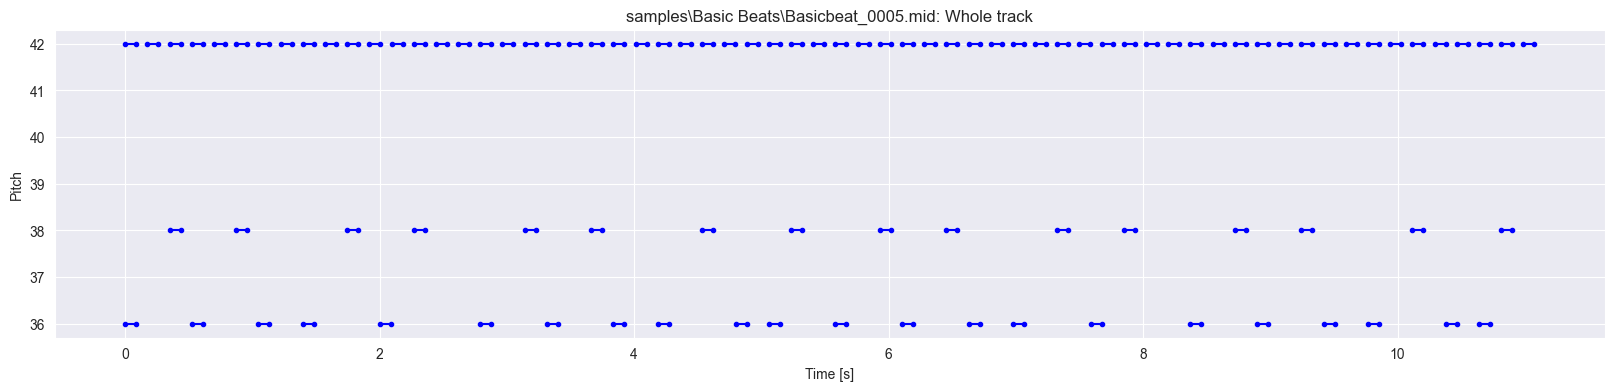

In [7]:
for filename in filenames[:5]:
    raw_notes = midi_to_notes(filename)
    plot_piano_roll(raw_notes)

In [22]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str,
                  velocity: int = 100) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])

        note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']),
                                start=start, end=end)
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Extranct all notes from dataset

In [12]:
num_files = 10
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

Number of notes parsed: 1001


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [13]:
def create_sequences(dataset: tf.data.Dataset, seq_length: int,
                     vocab_size = 128) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

In [14]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [15]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [16]:
# Developing the model

input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = Input(input_shape)
x = LSTM(128)(inputs)

outputs = {'pitch': Dense(128, name='pitch')(x),
           'step': Dense(1, name='step')(x),
           'duration': Dense(1, name='duration')(x),
          }

model = Model(inputs, outputs)

loss = {'pitch': SparseCategoricalCrossentropy(from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': mse_with_positive_pressure,
       }

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [17]:
# Creating the necessary callbacks

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./training_checkpoints/ckpt_{epoch}', save_weights_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,
                                              verbose=1, restore_best_weights=True),]

In [18]:
# Compiling and fitting the model

model.compile(loss = loss,
              loss_weights = {'pitch': 0.05, 'step': 1.0, 'duration':1.0,},
              optimizer = optimizer)

epochs = 50

history = model.fit(train_ds,
                    epochs=epochs,
                    callbacks=callbacks,)

Epoch 1/50
15/15 [==============================] - 3s 63ms/step - loss: 0.2553 - duration_loss: 0.0159 - pitch_loss: 4.6432 - step_loss: 0.0072
Epoch 2/50
15/15 [==============================] - 0s 15ms/step - loss: 1.0139 - duration_loss: 0.3530 - pitch_loss: 1.9686 - step_loss: 0.5625
Epoch 3/50
15/15 [==============================] - 0s 15ms/step - loss: 0.2647 - duration_loss: 0.0111 - pitch_loss: 4.4554 - step_loss: 0.0309
Epoch 4/50
15/15 [==============================] - 0s 15ms/step - loss: 0.2268 - duration_loss: 0.0093 - pitch_loss: 4.1756 - step_loss: 0.0087
Epoch 5/50
15/15 [==============================] - 0s 15ms/step - loss: 0.1346 - duration_loss: 0.0089 - pitch_loss: 2.3402 - step_loss: 0.0086
Epoch 6/50
15/15 [==============================] - 0s 15ms/step - loss: 0.0661 - duration_loss: 0.0089 - pitch_loss: 1.0176 - step_loss: 0.0063
Epoch 7/50
15/15 [==============================] - 0s 15ms/step - loss: 0.0650 - duration_loss: 0.0091 - pitch_loss: 0.9924 - ste

In [19]:
def predict_next_note(notes: np.ndarray, keras_model: tf.keras.Model,
                      temperature: float = 1.0) -> int:
    """Generates a note IDs using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [20]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes while the pitch is normalized similar to training sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0

for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

generated_notes.head(10)

1/1 [==============================] - 0s 15ms/step


,pitch,step,duration,start,end
0,42,0.069278,0.122636,0.069278,0.191914
1,111,0.569785,0.493966,0.639063,1.133029
2,112,0.660621,0.488705,1.299684,1.788389
3,42,0.687091,0.522284,1.986775,2.509060
4,46,0.665453,0.658708,2.652228,3.310936
5,42,0.696926,0.681534,3.349154,4.030688
6,35,0.704704,0.709644,4.053859,4.763503
7,46,0.713764,0.737775,4.767623,5.505398
8,5,0.718128,0.726947,5.485751,6.212698
9,42,0.635615,0.729607,6.121366,6.850973


In [21]:
out_file = 'output.midi'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)

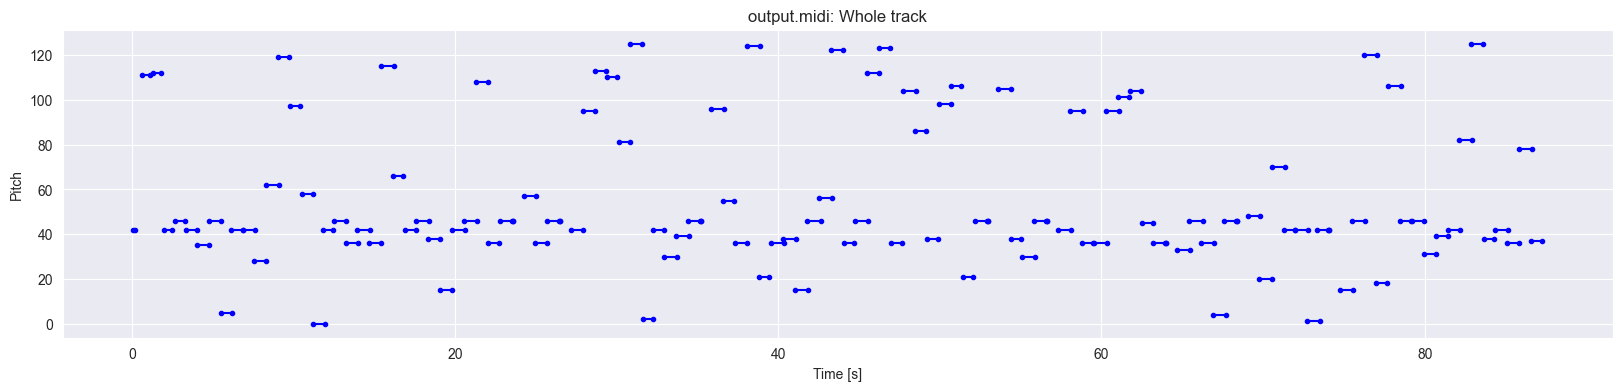

In [25]:
generated_notes = midi_to_notes(out_file)
plot_piano_roll(generated_notes)